
# Стохастические бандиты

Класс стохастических бандитов с бернулиевским распределением выигрышей. 

In [37]:
from scipy import stats as st

class BernoulliBandit:
    #принимает на вход список из K>=2 чисел из [0,1]
    def __init__(self, means):
        self._means = means
        self._best_mean = max(means)
        self.k = len(means)
        self.current_regret = 0
        self.rewards = [0 for i in range(self.k)]
        self.num_plays = [0 for i in range(self.k)]
        self.emperic_means = [0 for i in range(self.k)]        
  
    #Функция возвращает число ручек
    def K(self):
        return self.k

    #Принимает параметр 0 <= a <= K-1 и возвращает реализацию случайной величины 
    #X c P[X=1] равной среднему значению выигрыша ручки a+1
    def pull(self, a):
        reward = st.bernoulli.rvs(p=self._means[a])
        self.current_regret += st.bernoulli.rvs(p=self._best_mean) - reward
        self.num_plays[a] += 1
        self.rewards[a] += reward
        self.emperic_means[a] = self.rewards[a] / self.num_plays[a]
        return reward

    #Возвращает текущее значение регрета
    def regret(self):
        return self.current_regret

In [41]:
bandit = BernoulliBandit([0.9, 0.7])



Алгоритм "Следуй за лидером": 


1.   Сыграть каждое действие 1 раз
2.   Играть действие (ручку) с максимальным на данный момент средним выигрышем 

P.S. То есть сначала мы играем каждую ручку. Полученые выигрыши - стартовое приближение для среднего выигрыша.



In [40]:
def FollowTheLeader(bandit, T):
    #Реализутеся стратегия "Следуй за лидером" на протяжении Т раундов
    for i in range(bandit.k):
        bandit.pull(i)
    for i in range(T - bandit.k):
        a = bandit.emperic_means.index(max(bandit.emperic_means))
        bandit.pull(a)

In [43]:
from tqdm.notebook import tqdm

#Производится оценка среднего регрета для бандита с 2 ручками и алгоритма "Следуй за лидером"
mean_regret1 = []
num_sim = 1000
for T in tqdm([100*i for i in range(1, 11)]):
    sum_reg = 0
    for j in range(num_sim):
        bandit = BernoulliBandit([0.5, 0.6])
        FollowTheLeader(bandit, T)
        sum_reg += bandit.current_regret
    mean_regret1.append(sum_reg / num_sim)

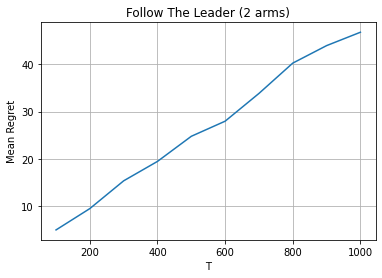

In [49]:
from matplotlib import pyplot as plt

#График зависимости регрета от раунда
plt.plot([100*i for i in range(1, 11)], mean_regret1)
plt.grid()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('Follow The Leader (2 arms)')
plt.show()

In [48]:
#Производится оценка среднего регрета для бандита с 10 ручками и алгоритма "Следуй за лидером"
mean_regret2 = []
num_sim = 1000
for T in tqdm([100*i for i in range(1, 11)]):
    sum_reg = 0
    for j in range(num_sim):
        bandit = BernoulliBandit([0.4 + 0.05*i for i in range(10)])
        FollowTheLeader(bandit, T)
        sum_reg += bandit.current_regret
    mean_regret2.append(sum_reg / num_sim)

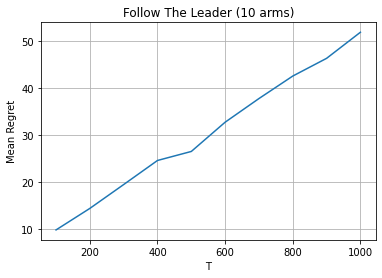

In [50]:
#График зависимости регрета от раунда
plt.plot([100*i for i in range(1, 11)], mean_regret2)
plt.grid()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('Follow The Leader (10 arms)')
plt.show()

Алгоритм Explore-First

In [51]:
def ExploreFirst(bandit, T, k):
    #Алгоритм Explore-First (k-число раз, сколько раз мы играем каждую ручку до exploitation фазы) 
    for i in range(bandit.k):
        for j in range(k):
            bandit.pull(i)
    for i in range(T - bandit.k*k):
        a = bandit.emperic_means.index(max(bandit.emperic_means))
        bandit.pull(a)

In [59]:
import numpy as np

#Производится оценка среднего регрета для бандита с 2 ручками и алгоритма Explore-First
mean_regret3 = []
num_sim = 1000
for T in tqdm([100*i for i in range(1, 11)]):
    sum_reg = 0
    k = round((np.log(T)**(1/3) * T**(2/3)) / 2)
    for j in range(num_sim):
        bandit = BernoulliBandit([0.5, 0.6])
        ExploreFirst(bandit, T, k)
        sum_reg += bandit.current_regret
    mean_regret3.append(sum_reg / num_sim)

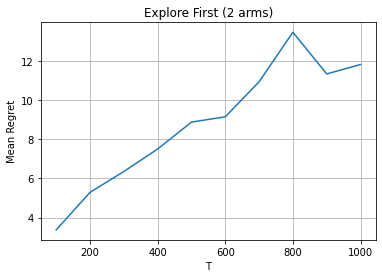

In [60]:
#График зависимости регрета от раунда
plt.plot([100*i for i in range(1, 11)], mean_regret3)
plt.grid()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('Explore First (2 arms)')
plt.show()

In [143]:
#Производится оценка среднего регрета для бандита с 10 ручками и алгоритма Explore-First
mean_regret4 = []
num_sim = 1000
for T in tqdm([100*i for i in range(1, 11)]):
    sum_reg = 0
    k = round((np.log(T)**(1/3) * T**(2/3)) / 50) + 1 
    for j in range(num_sim):
        bandit = BernoulliBandit([0.4 + 0.05*i for i in range(10)])
        ExploreFirst(bandit, T, k)
        sum_reg += bandit.current_regret
    mean_regret4.append(sum_reg / num_sim)

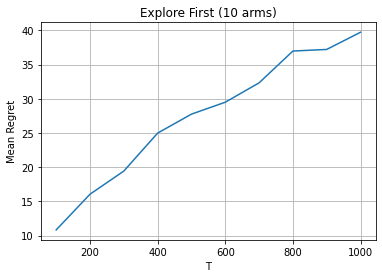

In [144]:
#График зависимости регрета от раунда
plt.plot([100*i for i in range(1, 11)], mean_regret4)
plt.grid()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('Explore First (10 arms)')
plt.show()

Алгоритм $\varepsilon$-Greedy

In [77]:
def EGreedy(bandit, T, e):
    #Алгоритм Epsilon-Greedy 
    k = bandit.k
    for t in range(T):
        if st.bernoulli.rvs(p=e):
            a = np.random.randint(0, k)
        else:
            a = bandit.emperic_means.index(max(bandit.emperic_means))
        bandit.pull(a)

In [78]:
#Производится оценка среднего регрета для бандита с 2 ручками и алгоритма E-Greedy
mean_regret5 = []
num_sim = 1000
for T in tqdm([100*i for i in range(1, 11)]):
    sum_reg = 0
    e = (2*np.log(T))**(1/3) * T**(-1/3)
    for j in range(num_sim):
        bandit = BernoulliBandit([0.5, 0.6])
        EGreedy(bandit, T, e)
        sum_reg += bandit.current_regret
    mean_regret5.append(sum_reg / num_sim)

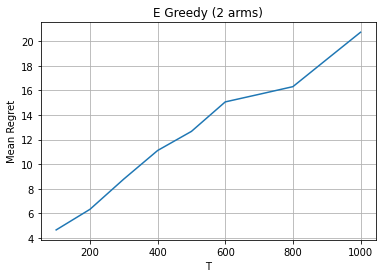

In [79]:
#График зависимости регрета от раунда
plt.plot([100*i for i in range(1, 11)], mean_regret5)
plt.grid()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('E Greedy (2 arms)')
plt.show()

In [149]:
#Производится оценка среднего регрета для бандита с 10 ручками и алгоритма E-Greedy
mean_regret6 = []
num_sim = 1000
for T in tqdm([100*i for i in range(1, 11)]):
    sum_reg = 0
    e = 0.5*(10*np.log(T))**(1/3) * T**(-1/3)
    for j in range(num_sim):
        bandit = BernoulliBandit([0.4 + 0.05*i for i in range(10)])
        EGreedy(bandit, T, e)
        sum_reg += bandit.current_regret
    mean_regret6.append(sum_reg / num_sim)

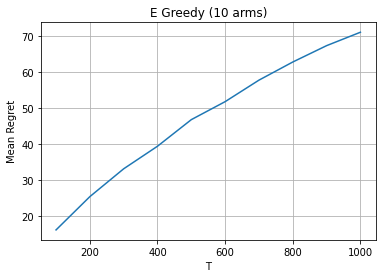

In [150]:
#График зависимости регрета от раунда
plt.plot([100*i for i in range(1, 11)], mean_regret6)
plt.grid()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('E Greedy (10 arms)')
plt.show()

Aлгоритм Successive Elimination

In [135]:
def SuccessiveElimination(bandit, T):
    #Алгоритм Successive Elimination
    for i in range(bandit.k):
        bandit.pull(i)
    r = (2*np.log(T))**0.5
    T = T - bandit.k
    active = [i for i in range(bandit.k)]
    n = 1
    while T > 0:
        max_emp_mean = max([bandit.emperic_means[i] for i in active])
        active = [i for i in active if bandit.emperic_means[i] + 2*r >= max_emp_mean]
        for i in active:
            bandit.pull(i)
            T -= 1
        n += 1
        r *= 0.8*((n-1)/n)**0.5

In [126]:
#Производится оценка среднего регрета для бандита с 2 ручками и алгоритма SuccessiveElimination
mean_regret7 = []
num_sim = 1000
for T in tqdm([100*i for i in range(1, 11)]):
    sum_reg = 0
    for j in range(num_sim):
        bandit = BernoulliBandit([0.5, 0.6])
        SuccessiveElimination(bandit, T)
        sum_reg += bandit.current_regret
    mean_regret7.append(sum_reg / num_sim)

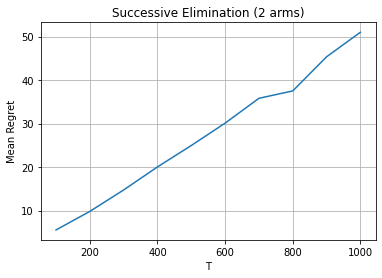

In [127]:
#График зависимости регрета от раунда
plt.plot([100*i for i in range(1, 11)], mean_regret7)
plt.grid()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('Successive Elimination (2 arms)')
plt.show()

In [136]:
#Производится оценка среднего регрета для бандита с 10 ручками и алгоритма SuccessiveElimination
mean_regret8 = []
num_sim = 1000
for T in tqdm([100*i for i in range(1, 11)]):
    sum_reg = 0
    for j in range(num_sim):
        bandit = BernoulliBandit([0.4 + 0.05*i for i in range(10)])
        SuccessiveElimination(bandit, T)
        sum_reg += bandit.current_regret
    mean_regret8.append(sum_reg / num_sim)

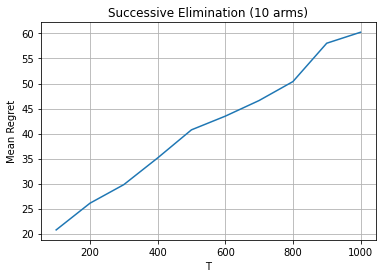

In [137]:
#График зависимости регрета от раунда
plt.plot([100*i for i in range(1, 11)], mean_regret8)
plt.grid()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('Successive Elimination (10 arms)')
plt.show()

Алгоритм UCB

In [140]:
def UCB(bandit, T):
    #Алгоритм UCB
    for i in range(bandit.k):
        bandit.pull(i)
    r = [(2*np.log(T))**0.5 for i in range(bandit.k)]
    for i in range(T - bandit.k):
        ucb = [x + y for x, y in zip(bandit.emperic_means, r)]
        a = ucb.index(max(ucb))
        bandit.pull(a)
        n = bandit.num_plays[a]
        r[a] *= 0.8*((n-1)/n)**0.5

In [114]:
#Производится оценка среднего регрета для бандита с 2 ручками и алгоритма UCB
mean_regret9 = []
num_sim = 1000
for T in tqdm([100*i for i in range(1, 11)]):
    sum_reg = 0
    for j in range(num_sim):
        bandit = BernoulliBandit([0.5, 0.6])
        UCB(bandit, T)
        sum_reg += bandit.current_regret
    mean_regret9.append(sum_reg / num_sim)

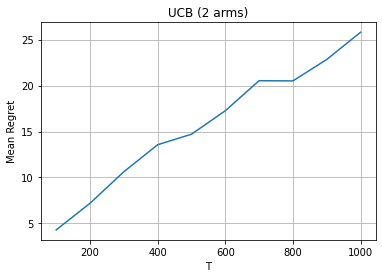

In [116]:
#График зависимости регрета от раунда
plt.plot([100*i for i in range(1, 11)], mean_regret9)
plt.grid()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('UCB (2 arms)')
plt.show()

In [141]:
#Производится оценка среднего регрета для бандита с 10 ручками и алгоритма UCB
mean_regret10 = []
num_sim = 1000
for T in tqdm([100*i for i in range(1, 11)]):
    sum_reg = 0
    for j in range(num_sim):
        bandit = BernoulliBandit([0.4 + 0.05*i for i in range(10)])
        UCB(bandit, T)
        sum_reg += bandit.current_regret
    mean_regret10.append(sum_reg / num_sim)

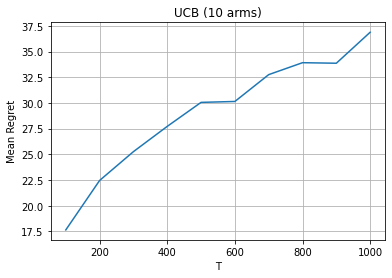

In [142]:
#График зависимости регрета от раунда
plt.plot([100*i for i in range(1, 11)], mean_regret10)
plt.grid()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('UCB (10 arms)')
plt.show()

### Сравнение результатов



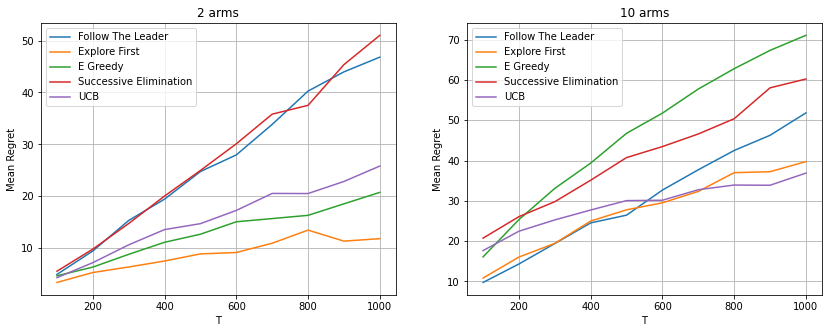

In [156]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot([100*i for i in range(1, 11)], mean_regret1, label='Follow The Leader')
plt.plot([100*i for i in range(1, 11)], mean_regret3, label='Explore First')
plt.plot([100*i for i in range(1, 11)], mean_regret5, label='E Greedy')
plt.plot([100*i for i in range(1, 11)], mean_regret7, label='Successive Elimination')
plt.plot([100*i for i in range(1, 11)], mean_regret9, label='UCB')
plt.grid()
plt.legend()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('2 arms')
plt.subplot(1, 2, 2)
plt.plot([100*i for i in range(1, 11)], mean_regret2, label='Follow The Leader')
plt.plot([100*i for i in range(1, 11)], mean_regret4, label='Explore First')
plt.plot([100*i for i in range(1, 11)], mean_regret6, label='E Greedy')
plt.plot([100*i for i in range(1, 11)], mean_regret8, label='Successive Elimination')
plt.plot([100*i for i in range(1, 11)], mean_regret10, label='UCB')
plt.grid()
plt.legend()
plt.xlabel('T')
plt.ylabel('Mean Regret')
plt.title('10 arms')
plt.show()